In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import sklearn
from math import *
from prettytable import PrettyTable
from functools import partial
from decimal import Decimal
import sympy
import time

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False  # 解决无法显示符号的问题
# palette = "deep"
# sns.set(font="Microsoft YaHei", font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

In [62]:
from mcm_cn2023.utils.util import *

In [63]:
'''
200,0,-197.2
0,0,-24.4
200,250,-65.20


0,250,-84.4
'''

'\n200,0,-197.2\n0,0,-24.4\n200,250,-65.20\n\n\n0,250,-84.4\n'

In [64]:
A = sympy.Point3D(nm2m(200 * 0.02), 0, 197.2)
B = sympy.Point3D(0, 0, 24.4)
C = sympy.Point3D(nm2m(200 * 0.02), nm2m(250 * 0.02), 65.20)
# 假设 C 抬高搞和 B 一样的高度
BC平均z = (B.z + C.z) / 2
C = sympy.Point3D(nm2m(200 * 0.02), nm2m(250 * 0.02), BC平均z)
B = sympy.Point3D(0, 0, BC平均z)

D = sympy.Point3D(0, nm2m(250 * 0.02), 84.4)

ABC = sympy.Plane(A, B, C)
BCD = sympy.Plane(B, C, D)

xoy = sympy.Plane((1, 0, 0), (0, 1, 0), (1, 1, 0))

In [65]:
ABC坡度 = 计算两平面夹角(ABC, xoy, False)
BCD坡度 = 计算两向量夹角(
    np.array(BCD.normal_vector).astype(float),
    -np.array(xoy.normal_vector).astype(float),
    False,
)

print(f"ABC坡度 {degrees(ABC坡度)}")
print(f"BCD坡度 {degrees(BCD坡度)}")

ABC坡度 1.5091350335178098
BCD坡度 0.39222203141528517


In [66]:
def 求解(坡度: float, 海水总深度: float, 斜坡地面长度: float, 长度计算函数):
    theta = radians(120)
    alpha = 坡度
    O = sympy.Point2D(0, 0)
    A1 = O
    C = sympy.Point2D(斜坡地面长度, tan(alpha) * 斜坡地面长度)
    斜坡 = sympy.Line2D(O, C)

    def aim(参考点A: sympy.Point2D):
        # print("======================")
        A = 参考点A
        A到M的水平距离 = (海水总深度 - A.y) * tan(theta / 2)
        M = sympy.Point2D(
            A.x + A到M的水平距离,
            海水总深度,
        )

        右侧扫描线 = sympy.Line2D(
            M,
            (M.x + A到M的水平距离, A.y),
        )
        # B = 斜坡.intersection(右侧扫描线)[0]
        Bpos = find_intersection(斜坡.p1, 斜坡.p2, 右侧扫描线.p1, 右侧扫描线.p2)
        B = sympy.Point2D(Bpos[0], Bpos[1])

        AB = sqrt((A.x - B.x) ** 2 + (A.y - B.y) ** 2)
        ANext = B - 斜坡.direction.unit * AB * 0.1
        return M, B, ANext, AB

    def solve():
        ArrM = []

        ANext = A1
        beforeBx = 0
        总长度 = 0
        while True:
            M, B, ANext, AB = aim(ANext)
            ArrM.append(M)
            总长度 += 长度计算函数(float(M.x))
            print(f"B.x >= C.x {float(B.x)} {float(C.x)} 总长度：{总长度}")
            if B.x >= C.x or B.x - beforeBx < 1:
                break

            beforeBx = float(B.x)

        return ArrM

    return solve()

In [67]:
求解1 = 求解(
    坡度=ABC坡度,
    海水总深度=abs(A.z),
    斜坡地面长度=nm2m(20 / sqrt(41)),
    长度计算函数=lambda x: 41 * x / 20,
)

B.x >= C.x 653.3092346362032 5784.67614035397 总长度：700.198859467793
B.x >= C.x 1189.9684364852494 5784.67614035397 总长度：2550.7508477011497
B.x >= C.x 1684.4716870801956 5784.67614035397 总长度：5461.292787745031
B.x >= C.x 2140.130444083586 5784.67614035397 总长度：9348.559761035853
B.x >= C.x 2559.9960416991294 5784.67614035397 总长度：14135.827521071627
B.x >= C.x 2946.880124033905 5784.67614035397 总长度：19752.398706912798
B.x >= C.x 3303.3734733677384 5784.67614035397 总长度：26133.129415924966
B.x >= C.x 3631.863359413982 5784.67614035397 总长度：33217.99296544219
B.x >= C.x 3934.5495257514917 5784.67614035397 总长度：40951.67792206602
B.x >= C.x 4213.458920481523 5784.67614035397 总长度：49283.21770678996
B.x >= C.x 4470.459269753955 5784.67614035397 总长度：58165.64929558763
B.x >= C.x 4707.271585058304 5784.67614035397 总长度：67555.69872994159
B.x >= C.x 4925.481688035088 5784.67614035397 总长度：77413.49133132357
B.x >= C.x 5126.550829983804 5784.67614035397 总长度：87702.28467906745
B.x >= C.x 5311.8254771815045 5784.67614

In [76]:
BQuate = sympy.Point2D(B.x, B.y)  # 水平面上的 B
CQuate = sympy.Point2D(C.x, C.y)  # 水平面上的 C
AQuate = sympy.Point2D(A.x, A.y)
DQuate = sympy.Point2D(D.x, D.y)
水平面上的BC = sympy.Line2D(BQuate, CQuate)


def 计算ABC面中的答案():
    def 计算测线线段(M在求解平面中的坐标点: sympy.Point2D):
        M = M在求解平面中的坐标点
        alpha = atan(4 / 5)
        M在水平面上的坐标点 = sympy.Point2D(
            AQuate.distance(BQuate) - cos(alpha) * M.x,
            M.x * sin(alpha),
        )
        测线直线 = sympy.Line2D(M在水平面上的坐标点, M在水平面上的坐标点 + 水平面上的BC.direction.unit)

        测线线段 = sympy.Segment2D(
            sympy.Line2D(AQuate, BQuate).intersection(测线直线)[0],
            sympy.Line2D(AQuate, CQuate).intersection(测线直线)[0],
        )

        return 测线线段

    def 转测线线段(解):
        resultArr = list(map(lambda x: 计算测线线段(x), 解))

        print(f"resultArr[0] {float(resultArr[0].length)}")
        s = sum(map(lambda x: float(x.length), resultArr))
        print(f"长度: {s}")
        return resultArr

    def 转表格(segment: sympy.Segment2D):
        res = dict()
        res["起始点x"] = float(segment.p1.x)
        res["起始点y"] = float(segment.p1.y)
        res["终点x"] = float(segment.p2.x)
        res["终点y"] = float(segment.p2.y)
        res["长度"] = float(segment.length)
        return res

    dataABC面的数据 = list(map(转表格, 转测线线段(求解1)))
    xlsx = pd.DataFrame(dataABC面的数据)
    return xlsx


xlsxABC = 计算ABC面中的答案()
xlsxABC

resultArr[0] 700.1988594677997
长度: 132528.99666799232


,起始点x,起始点y,终点x,终点y,长度
0,6970.589240,0.0,7408.0,546.763450,700.198859
1,6251.969338,0.0,7408.0,1445.038328,1850.551988
2,5589.798864,0.0,7408.0,2272.751420,2910.541940
3,4979.643573,0.0,7408.0,3035.445533,3887.266973
4,4417.417539,0.0,7408.0,3738.228076,4787.267760
5,3899.355796,0.0,7408.0,4385.805255,5616.571186
6,3421.989126,0.0,7408.0,4982.513592,6380.730709
7,2982.120828,0.0,7408.0,5532.348965,7084.863550
8,2576.805308,0.0,7408.0,6038.993365,7733.684957
9,2203.328358,0.0,7408.0,6505.839553,8331.539785


In [69]:
求解2 = 求解(
    坡度=BCD坡度,
    海水总深度=abs(D.z),
    斜坡地面长度=nm2m(20 / sqrt(41)),
    长度计算函数=lambda x: 41 * x / 20,
)

B.x >= C.x 288.9441501949572 5784.67614035397 总长度：299.67943072556665
B.x >= C.x 542.8993021463331 5784.67614035397 总长度：1126.1398003645065
B.x >= C.x 791.4978797988042 5784.67614035397 总长度：2468.2699295733237
B.x >= C.x 1034.852867228495 5784.67614035397 总长度：4315.1930026638565
B.x >= C.x 1273.0748653836574 5784.67614035397 总长度：6656.261624264566
B.x >= C.x 1506.272142351055 5784.67614035397 总长度：9481.052980249688
B.x >= C.x 1734.5506825620691 5784.67614035397 总长度：12779.364100736984
B.x >= C.x 1958.0142349609055 5784.67614035397 总长度：16541.207223001184
B.x >= C.x 2176.7643601568443 5784.67614035397 总长度：20756.80525219556
B.x >= C.x 2390.900476581935 5784.67614035397 总长度：25416.58731781882
B.x >= C.x 2600.519905675057 5784.67614035397 总长度：30511.184423907565
B.x >= C.x 2805.7179161129316 5784.67614035397 总长度：36031.42519097751
B.x >= C.x 3006.5877671082753 5784.67614035397 总长度：41968.33168777826
B.x >= C.x 3203.220750794578 5784.67614035397 总长度：48313.1153509672
B.x >= C.x 3395.7062337169177 5784.6

In [77]:
def 计算BCD面中的答案(求解):
    def 计算测线线段(M在求解平面中的坐标点: sympy.Point2D):
        M = M在求解平面中的坐标点
        alpha = atan(4 / 5)
        M在水平面上的坐标点 = sympy.Point2D(
            M.x * cos(alpha),
            DQuate.distance(BQuate) - sin(alpha) * M.x,
        )
        测线直线 = sympy.Line2D(M在水平面上的坐标点, M在水平面上的坐标点 + 水平面上的BC.direction.unit)

        测线线段 = sympy.Segment2D(
            sympy.Line2D(BQuate, DQuate).intersection(测线直线)[0],
            sympy.Line2D(DQuate, CQuate).intersection(测线直线)[0],
        )

        return 测线线段

    def 转测线线段(解):
        resultArr = list(map(lambda x: 计算测线线段(x), 解))

        print(f"resultArr[0] {float(resultArr[0].length)}")
        s = sum(map(lambda x: float(x.length), resultArr))
        print(f"长度: {s}")
        return resultArr

    def 转表格(segment: sympy.Segment2D):
        res = dict()
        res["起始点x"] = float(segment.p1.x)
        res["起始点y"] = float(segment.p1.y)
        res["终点x"] = float(segment.p2.x)
        res["终点y"] = float(segment.p2.y)
        res["长度"] = float(segment.length)
        return res

    data = list(map(转表格, 转测线线段(求解)))
    xlsx = pd.DataFrame(data)
    return xlsx


xlsxBCD = 计算BCD面中的答案(求解2)
xlsxBCD

resultArr[0] 299.6794307255704
长度: 198804.67622551453


,起始点x,起始点y,终点x,终点y,长度
0,0.0,9025.989680,187.208256,9260.0,299.679431
1,0.0,8614.642875,516.285700,9260.0,826.460370
2,0.0,8211.972444,838.422045,9260.0,1342.130129
3,0.0,7817.795379,1153.763697,9260.0,1846.923073
4,0.0,7431.932533,1462.453974,9260.0,2341.068622
5,0.0,7054.208537,1764.633170,9260.0,2824.791356
6,0.0,6684.451722,2060.438622,9260.0,3298.311120
7,0.0,6322.494040,2350.004768,9260.0,3761.843122
8,0.0,5968.170986,2633.463211,9260.0,4215.598029
9,0.0,5621.321526,2910.942779,9260.0,4659.782066


In [71]:
跨越整个海域的额外长度 = nm2m(40 / sqrt(41))
跨越整个海域的额外长度

11569.352280707939

In [86]:
xlsx = pd.concat([xlsxABC, xlsxBCD])
xlsx.to_excel("第四问.xlsx")
xlsx

,起始点x,起始点y,终点x,终点y,长度
0,6970.589240,0.000000,7408.000000,546.763450,700.198859
1,6251.969338,0.000000,7408.000000,1445.038328,1850.551988
2,5589.798864,0.000000,7408.000000,2272.751420,2910.541940
3,4979.643573,0.000000,7408.000000,3035.445533,3887.266973
4,4417.417539,0.000000,7408.000000,3738.228076,4787.267760
5,3899.355796,0.000000,7408.000000,4385.805255,5616.571186
6,3421.989126,0.000000,7408.000000,4982.513592,6380.730709
7,2982.120828,0.000000,7408.000000,5532.348965,7084.863550
8,2576.805308,0.000000,7408.000000,6038.993365,7733.684957
9,2203.328358,0.000000,7408.000000,6505.839553,8331.539785


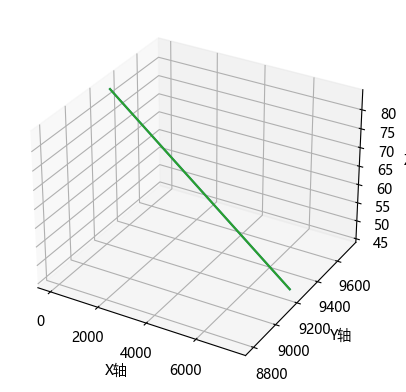

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot([A.x, B.x], [A.y, B.y], [A.z, B.z])
ax.plot([A.x, C.x], [A.y, C.y], [A.z, C.z])
ax.plot([D.x, C.x], [D.y, C.y], [D.z, C.z])
ax.plot([D.x, B.x], [D.y, B.y], [D.z, B.z])


# 设置坐标轴标签
ax.set_xlabel("X轴")
ax.set_ylabel("Y轴")
ax.set_zlabel("Z轴")

# 显示图形
plt.show()